# Imports

In [1]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from skimage.io import imread, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

# Load cleaned dataframe

In [2]:
# Load cleaned data table
df = pd.read_csv('/home/lfay/mitigate-bias/chexpert/chexpert_plus_240401_cleaned.csv')
len(df)

112105

False

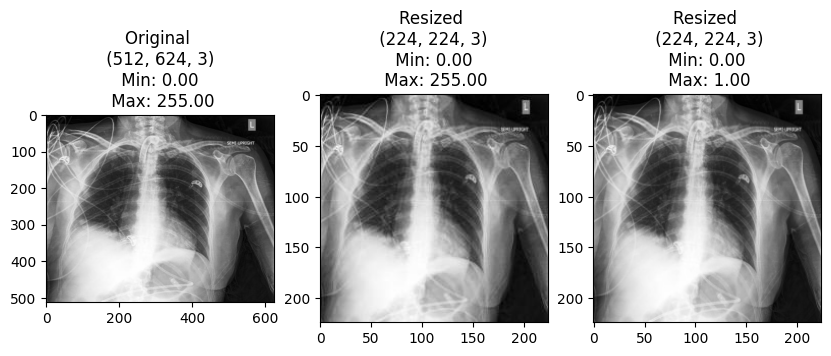

In [8]:
# subplots
img_f = imread('/home/lfay/CheXpert-v1.0-512/images/'+'train/patient42142/study5/view1_frontal.jpg')
img_f_resized = imread('/home/lfay/mitigate-bias/chexpert/preproc_224x224'+'/patient42142_study5_view1_frontal.jpg')
img_f_new_resized = resize(img_f, (224, 224))


fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_f, cmap='gray')
ax[0].title.set_text(f'Original \n {img_f.shape} \n Min: {img_f.min() :.2f} \n Max: {img_f.max() :.2f}')

ax[1].imshow(img_f_resized, cmap='gray')
ax[1].title.set_text(f'Resized \n {img_f_resized.shape} \n Min: {img_f_resized.min() :.2f} \n Max: {img_f_resized.max() :.2f}')
ax[2].imshow(img_f_new_resized, cmap='gray')
ax[2].title.set_text(f'Resized \n {img_f_new_resized.shape}' + f'\n Min: {img_f_new_resized.min() :.2f} \n Max: {img_f_new_resized.max() :.2f}')

# is img_f_resized == img_f_new_resized?
(img_f_resized == img_f_new_resized).all()


# Add path to resized dataframe

In [4]:
# Add column to dataframe if path to resized images from train/patient42142/study5/view1_frontal.jpg to preproc_224x224/patient42142_study5_view1_frontal.jpg
df['path_to_resized_image'] = df['path_to_image'].apply(lambda x: x.replace('train/', ''))

# remove / and replace with _ in the path
df['path_to_resized_image'] = df['path_to_resized_image'].apply(lambda x: x.replace('/', '_'))

# add preproc_224x224 to the path
df['path_to_resized_image'] = df['path_to_resized_image'].apply(lambda x: os.path.join('/home/lfay/mitigate-bias/chexpert/preproc_224x224', x))


In [5]:
# check if path_to_resized_image exists, then take path_to_image from same row if not resizes image, normalize to [0,255] and save it

def resize_and_save(row):
    if os.path.exists(row['path_to_resized_image']):
        return
    orig_path = "/home/lfay/CheXpert-v1.0-512/images/" + row['path_to_image']
    img = imread(orig_path)
    img_resized = resize(img, (224, 224), preserve_range=True)
    imsave(row['path_to_resized_image'], img_resized.astype(np.uint8))

for i, row in df.iterrows():
    resize_and_save(row)


In [ ]:
# Function to check file existence
def check_path_exists(img_path):
    full_path = os.path.join(img_path)
    return os.path.exists(full_path), full_path

# Parallelize the process using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(executor.map(check_path_exists, df['path_to_resized_image']))

# Split results into existing and missing paths
existing_paths = [res for res, _ in results if res]
missing_paths = [path for res, path in results if not res]

# Print the counts
print(len(existing_paths))
print(len(missing_paths))

# Optionally print missing paths
for path in missing_paths:
    print(path)


In [23]:
if (len(missing_paths) == 0) and (len(existing_paths) == len(df['path_to_image'])):
    print("All images exist in resized format (224x224)")
else:
    print("Some images are missing in resized format (224x224)")

NameError: name 'missing_paths' is not defined

### Save df to df_cleaned including now the path to resized images

In [6]:
# df.to_csv('/data4/lfay/chexpert_plus_240401_cleaned.csv')